In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.io import savemat
from scipy.optimize import fsolve


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, t_u, x_u, layers, lt, ut):
    
        self.t_u = t_u
        self.x_u = x_u
        
        self.lt = lt
        self.ut = ut
                
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be 
        #            automatically updated in the original tf.Variable
        
        # define the loss function
        self.loss = self.loss_NN()
        
        self.optimizer_Adam = tf.optimizers.Adam()

    
    '''
    Functions used to establish the initial neural network
    ===============================================================
    '''
                
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32))
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lt)/(self.ut - self.lt) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    
    '''
    Functions used to building the physics-informed contrainst and loss
    ===============================================================
    '''
    
    def net_u(self, t):
        x = self.neural_net(t, self.weights, self.biases)
        return x
    
    
    @tf.function
    # calculate the physics-informed loss function
    def loss_NN(self):
        self.x_pred = self.net_u(self.t_u) 
        loss = tf.reduce_mean(tf.square(self.x_u - self.x_pred)) * 10
        return loss
    
    
    
    '''
    Functions used to define ADAM optimizers
    ===============================================================
    '''
    # define the function to apply the ADAM optimizer
    def Adam_optimizer(self, nIter):
        varlist = self.train_variables
        start_time = time.time()
        for it in range(nIter):
            self.optimizer_Adam.minimize(self.loss_NN, varlist)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.loss_NN()
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                
                
    '''
    Functions used to define L-BFGS optimizers
    ===============================================================
    '''
    
    # A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    def Lbfgs_function(self):
        # obtain the shapes of all trainable parameters in the model
        varlist = self.train_variables
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)
    
        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = [] # stitch indices
        part = [] # partition indices
        
        self.start_time = time.time()
    
        for i, shape in enumerate(shapes):
            n = np.product(shape)
            idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
            part.extend([i]*n)
            count += n
    
        part = tf.constant(part)
        
        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self
            
            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                self.train_variables[i].assign(tf.reshape(param, shape))
                
                
        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self
    
            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model 
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_value = self.loss_NN()
    
            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_value, varlist)
            grads = tf.dynamic_stitch(idx, grads)
    
            # store loss value so we can retrieve later
            tf.py_function(f.history.append, inp=[loss_value], Tout=[])
                
            # print out iteration & loss
            f.iter.assign_add(1)
            
            if f.iter % 10 == 0:
                tf.print("Iter:", f.iter, "loss:", loss_value)
                
            return loss_value, grads
        
        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.history = []
        
        return f
    
    
    # define the function to apply the L-BFGS optimizer
    def Lbfgs_optimizer(self, nIter):
        
        func = self.Lbfgs_function()
    
        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, self.train_variables)
        
        max_nIter = tf.cast(nIter/3, dtype = tf.int32)
    
        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params, 
            tolerance=10e-9, max_iterations=max_nIter)
    
        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)
        
        
    '''
    Function used for training the model
    ===============================================================
    '''
        
    def train(self, nIter, idxOpt):
        if idxOpt == 1:
            # mode 1: running the Adam optimization
            self.Adam_optimizer(nIter)
        elif idxOpt == 2:
            # mode 2: running the Lbfgs optimization
            self.Lbfgs_optimizer(nIter)
        
        
    # @tf.function
    def predict(self, t):
        x_p = self.net_u(t)  
        return x_p

In [5]:
if __name__ == "__main__": 
     
    noise = 0.0

    np.random.seed(123)
    tf.random.set_seed(123)
    
    N_pd = 200
    layers = [1,5,1]
    
    def fun_test(t):
        # customize the function by the user
#        x = 1 - t**2 + tf.exp(-t)
        x = tf.sin(5*t)
#        x = abs(tf.tanh(t))
        return x
    
    t =np.linspace(-1,1,200)[:,None]
    x = fun_test(t)
    t_train = tf.cast(t, dtype = tf.float32)
    x_train = tf.cast(x, dtype = tf.float32)
    
    # Doman bounds
    lt = t.min(0)
    ut = t.max(0)
     
        
    model = PhysicsInformedNN(t_train, x_train, layers, lt, ut)
    
    start_time = time.time()                
    model.train(5000, 2)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
    t_intp = np.linspace(-1,1,N_pd)
    t_intp = tf.cast(t_intp, dtype=tf.float32)
    t_intp = tf.reshape(t_intp, [N_pd, 1])
    x_intp = fun_test(t_intp)
    
    x_pred =  model.predict(t_intp)

    
    error_x = np.linalg.norm(x_intp-x_pred,2)/np.linalg.norm(x_intp,2)
    print('Error u: %e' % (error_x))                     
    
    xmin = x_intp.numpy().min()
    xmax = x_intp.numpy().max()

Iter: 10 loss: 5.02758217
Iter: 20 loss: 4.83883572
Iter: 30 loss: 15.1134338
Iter: 40 loss: 0.731689632
Iter: 50 loss: 0.412388563
Iter: 60 loss: 3.32261086
Iter: 70 loss: 0.00530420896
Iter: 80 loss: 0.00220382726
Iter: 90 loss: 0.00189343456
Iter: 100 loss: 0.0123911342
Iter: 110 loss: 0.000555778737
Iter: 120 loss: 1.66778918e-05
Iter: 130 loss: 3.49908476e-08
Iter: 140 loss: 3.54367889e-11
Iter: 150 loss: 3.51402865e-11
Iter: 160 loss: 3.52589104e-11
Iter: 170 loss: 3.52589104e-11
Training time: 2.0022
Error u: 2.572083e-06


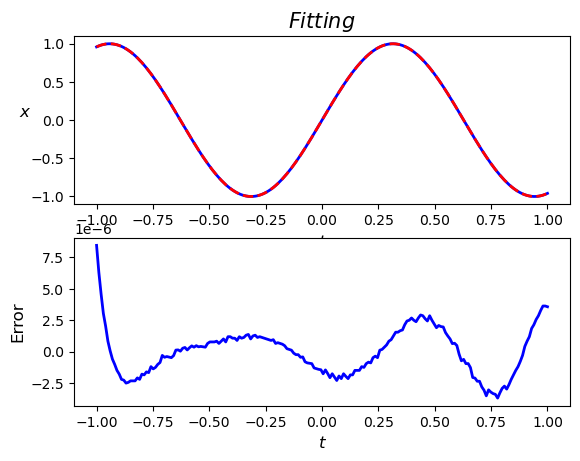

In [6]:
    ######################################################################
    ############################# Plotting ###############################
    ######################################################################    
    
    ax = plt.subplot(211)
    ax.plot(t_intp, x_intp, 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(t_intp, x_pred, 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$t$', fontsize = 12)
    ax.set_ylabel('$x$', fontsize = 12, rotation = 0)
    ax.set_title('$Fitting$', fontsize = 15)
    
    
    ax = plt.subplot(212)
    ax.plot(t_intp, x_intp-x_pred, 'b-', linewidth = 2)
    ax.set_xlabel('$t$', fontsize = 12)
    ax.set_ylabel('Error', fontsize = 12, rotation = 90)
    
    plt.show()